In [2]:
using BenchmarkTools, SpecialFunctions
using LinearAlgebra, Statistics
using Parameters
using Plots
using Optim #https://github.com/JuliaNLSolvers/Optim.jl
using Random, Distributions
gr(fmt=:png); # setting for easier display in jupyter notebooks
using TypedTables
using ThreadsX, Folds # these are multithreading tools
using QuantEcon
using SparseArrays
using BasisMatrices
using NLsolve

In [3]:
model_params = @with_kw (
    β= 0.96,
    R = 1.0292,
    γ = 3.0,
    amin = -3.0,
    amax = 16.0,
    Na=100,
    agrid = range(amin,amax,length=Na),
    Nshocks = 7,
    ρ = 0.20,
    σ = 0.3919,
    mc= rouwenhorst(Nshocks, ρ, σ),
    Niter = 500,
    )

##NamedTuple_kw#257 (generic function with 2 methods)

In [8]:
function consumption(R, a, ap, w)
    
        c = R*a .- ap .+ w
    
    return c
    
end

##########################################################################
##########################################################################

function utility(c, γ)
    
    if abs(γ - 1.0) < 1e-10
        
        (c < 1e-5 ? -1e10 : log(c)) 

    else
        (c < 1e-5 ? -1e10 : c^( 1.0 - γ) / (1.0 - γ)) 
    end

end

##########################################################################
##########################################################################

function make_utility(model_params)
    
    @unpack Na, Nshocks, γ, R, mc, agrid = model_params
    
    utility_grid = Array{Float64}(undef, Na, Na, Nshocks)
    
    a =  reshape(agrid, Na, 1)
    
    a_prime = reshape(agrid, 1, Na)
    
    for xxx = 1:Nshocks
        
        c = consumption(R, a, a_prime, exp.(mc.state_values[xxx]))
        
        utility_grid[:, :, xxx] = utility.(c, γ)
    
    end
    
    return utility_grid
    
end

##########################################################################
##########################################################################

function compute_EV(v::Array{T}, mc_probs::Vector{T}) where T
     
    # so mc_probs should be a 1 by Nshock row vector 
    # then v should be Nassset state, Nshock state matrix
    # we want to integrate this so transpose, so for a given
    # asset state integrate accross different shock outcomes
    
    return  (mc_probs' * v' )

end

##########################################################################
##########################################################################

function bellman_operator(v,u,mc,β)
    
        Na = size(u)[1]
        Nshocks = size(u)[3]
    
        Tv = Array{Float64}(undef, Na, Nshocks)
    
        for xxx in 1:Nshocks
                    
            βEV = compute_EV(β*v, mc.p[xxx,:])
            
            maximum!(view(Tv,:,xxx), u[:, :, xxx] .+ βEV )
            
            #this is fastest and writes on TV directly
            # lower number of allocations too
            # the view command is what allows the direct writing on 
            # a slice of the array, without it, nodice

        end
    
    return Tv
    
end


##########################################################################
##########################################################################

function bellman_operator(v,u,mc,β,policy::Matrix{CartesianIndex{2}})
    
        Na = size(u)[1]
        Nshocks = size(u)[3]
    
        Tv = Array{Float64}(undef, Na, Nshocks)
    
        for xxx in 1:Nshocks
                    
            βEV = compute_EV(β*v, mc.p[xxx,:])
            
            Tv[:, xxx], policy[:, xxx] = findmax(u[:, :, xxx] .+ βEV , dims = 2)
            
            #this is fastest and writes on TV directly
            # lower number of allocations too
            # the view command is what allows the direct writing on 
            # a slice of the array, without it, nodice

        end
    
    return Tv, policy
    
end

##########################################################################
##########################################################################

function value_function_itteration(model_params ; tol = 10^-3)
    
    @unpack Na, Nshocks, Niter, β, mc = model_params
    
    u = make_utility(model_params)

    Tv = zeros(Na, Nshocks)
    
    v = similar(Tv)

    for iter in 1:Niter
        
        Tv = bellman_operator(Tv,u,mc,β)
        #there is some advantage of having it
        # explicity, not always recreating the Tv 
        # array in the function
    
        test_tol = maximum(abs, Tv - v)
        
        if test_tol < tol
            
            #println("value function converged")
            #println(iter)
            #println(test_tol)
                        
            break
        end
        
        v = copy(Tv)
        #copy!(v, Tv)

    end
    
    policy = Array{CartesianIndex{2}}(undef, size(Tv))
            
    Tv, policy = bellman_operator(Tv,u,mc,β,policy)
    
    return Tv, policy
    
end


##########################################################################
##########################################################################


function make_transition_prob(model_params, asset_indx::Matrix{CartesianIndex{2}})
      
    @unpack Na, Nshocks, mc = model_params

    statesize = Int(Na*Nshocks)
    
    transition_prob = Array{Float64}(undef, statesize, statesize)
    
    foo = Array{Float64}(undef, 1, Na) 

    for ast = 1:Na
        
        ast_counter = Int((ast - 1)*Nshocks)
            
        for shk = 1:Nshocks
            
            fill!(foo, 0.0)
    
            foo[asset_indx[ast, shk][2]] = 1.0
    
            transition_prob[shk + ast_counter, :] = BasisMatrices.row_kron(foo, mc.p[shk,:]' )
            
            # this part on the row still confuses me a bit...need to explain better.
            
            #println(shk + ast_counter)
            
        end
        
    end
    
    return transition_prob
    
end


function fixed_dist(L::Array{T},Q::Array{T}) where T
    
    return transpose(Q) * L
    
end

##########################################################################
##########################################################################

function stationary_dist(Q::Array{Float64, 2})
    # this is faster than the quant econ canned routine
    # from lyon-waugh implementation
    
    L = zeros(size(Q)[1], 1)
    
    L[1] = 1.0
    
    max_it = 5000
    
    Lnew = similar(L)
    
    for xxx in 1:max_it
        
        Lnew = transpose(Q) * L
        #this ordering is also better in julia
        # than my matlab implementation of Q*L (1, na*nshock)
                
        err = maximum(abs, L - Lnew)
        
        copy!(L, Lnew)
        # this surprisingly makes a big difference
        # but in the vfi it causes a slowdown?
        
        err < 1e-10 && break
        
    end
    
    return L
end

stationary_dist (generic function with 1 method)

In [79]:
@btime value_function_itteration(test ; tol = 10^-3);

  182.346 ms (9580 allocations: 659.10 MiB)


In [54]:
@btime value_function_itteration(test ; tol = 10^-3);

  486.951 ms (20195 allocations: 1.25 GiB)


In [43]:
@btime stationary_dist(tprob);

  64.719 ms (1096 allocations: 6.02 MiB)


In [56]:
@btime stationary_dist(tprob);

  1.934 s (1748 allocations: 26.74 MiB)


  0.185623 seconds (14.52 k allocations: 256.402 MiB, 26.13% gc time)
vfi done
  0.010322 seconds (2.00 k allocations: 15.534 MiB)
  0.112489 seconds (896 allocations: 6.945 MiB)


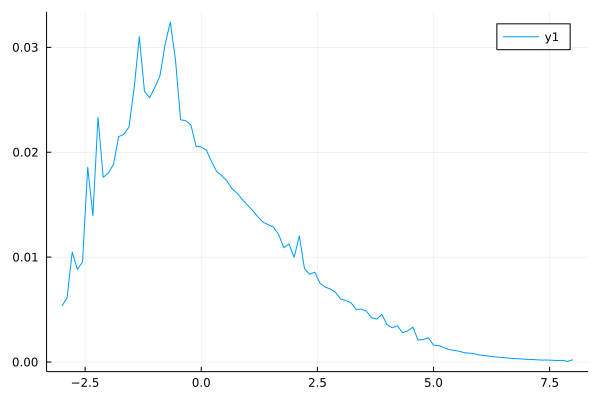

In [31]:
test = model_params(σ = 0.3919, Nshocks = 10, Na = 100, amin = -3.0, amax = 8)

@time vfout, pout = value_function_itteration(test ; tol = 10^-3);

println("vfi done")

@time tprob = make_transition_prob(test, pout);

@time  st = stationary_dist(tprob);

st = reshape(st,test.Nshocks,test.Na)'

plot(test.agrid, sum(st, dims = 2))

This approach implements solves for the fixed points using nlsolve's fixedpoint routine. It's fast, appears to be very robust.

  0.037345 seconds (6.67 k allocations: 63.194 MiB, 42.39% compilation time)
29
  0.010863 seconds (2.00 k allocations: 15.534 MiB)
  0.057956 seconds (5.41 k allocations: 18.496 MiB, 23.92% compilation time)
120


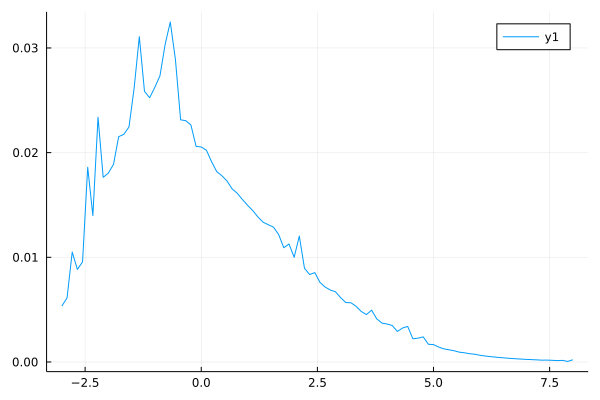

In [34]:
u = make_utility(test)

##########################################################

f(x) = bellman_operator(x,u,test.mc,test.β)

iv = zeros(test.Na, test.Nshocks)

@time sol = fixedpoint(f, iv, ftol = 1e-3)
println(sol.f_calls)
#this approach works very good....

policy = Array{CartesianIndex{2}}(undef, size(sol.zero))
            
vfout, pout = bellman_operator(sol.zero,u,test.mc,test.β,policy);

@time tprob = make_transition_prob(test, pout);

##########################################################

g(x) = fixed_dist(x, tprob)

iv = zeros(size(tprob)[1], 1)
    
iv[1] = 1.0

@time sol = fixedpoint(g, iv, ftol = 1e-10)
println(sol.f_calls)

st = reshape(sol.zero,test.Nshocks,test.Na)';

plot(test.agrid, sum(st, dims = 2))

In [29]:
sol.f_calls

25

  0.073621 seconds (5.41 k allocations: 18.496 MiB, 13.06% gc time, 23.10% compilation time)
120


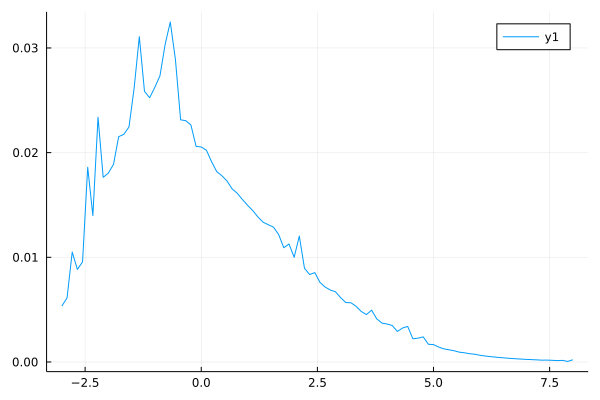

In [25]:
g(x) = fixed_dist(x, tprob)

iv = zeros(size(tprob)[1], 1)
    
iv[1] = 1.0

@time sol = fixedpoint(g, iv, ftol = 1e-10)
println(sol.f_calls)

st = reshape(sol.zero,test.Nshocks,test.Na)';

plot(test.agrid, sum(st, dims = 2))

fixed_dist (generic function with 1 method)

In [111]:
sol.f_calls

84